In [ ]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Planning: TODO Lists

Many agents use TODO lists as a critical navigation tool for steering through long-running, complex tasks. Claude Code leverages [plan mode](https://www.anthropic.com/engineering/claude-code-best-practices) to create structured TODO lists before executing tasks, utilizing a specific tool called `TodoWrite` based on the [Claude Code prompt](https://cchistory.mariozechner.at/). Each TODO item contains three key components: content (a short, specific task description), status (pending, in_progress, or completed), and a unique identifier for tracking progress.

The challenge with TODO lists lies in maintaining attention as context windows grow—the average Manus task uses approximately 50 tool calls, creating substantial risk of [context rot](https://research.trychroma.com/context-rot). Agents become vulnerable to drifting off-topic or forgetting earlier objectives during lengthy conversations or complicated tasks. By continuously rewriting and updating the TODO list, agents like Manus effectively recite their objectives at the end of the context, helping to [stay focused on task](https://manus.im/blog/Context-Engineering-for-AI-Agents-Lessons-from-Building-Manus) and prevent mission drift.

### State

**TODO(Geoff)** Can explain here that we define the state object 
* Explain `AgentState` (`langgraph.prebuilt.chat_agent_executor import AgentState`)
* Explain with `todo` we will simple overwrite the state with each tools call. 
* Explain `files` and `file_reducer`. 

In [ ]:
%%writefile ../src/deep_agents_from_scratch/state.py

"""State management for deep agents with TODO tracking and virtual file systems.

This module defines the extended agent state structure that supports:
- Task planning and progress tracking through TODO lists
- Context offloading through a virtual file system stored in state
- Efficient state merging with reducer functions
"""

from typing import Annotated, Literal, NotRequired, TypedDict

from langgraph.prebuilt.chat_agent_executor import AgentState


class Todo(TypedDict):
    """A structured task item for tracking progress through complex workflows.

    Attributes:
        content: Short, specific description of the task
        status: Current state - pending, in_progress, or completed
    """

    content: str
    status: Literal["pending", "in_progress", "completed"]


def file_reducer(left, right):
    """Merge two file dictionaries, with right side taking precedence.

    Used as a reducer function for the files field in agent state,
    allowing incremental updates to the virtual file system.

    Args:
        left: Left side dictionary (existing files)
        right: Right side dictionary (new/updated files)

    Returns:
        Merged dictionary with right values overriding left values
    """
    if left is None:
        return right
    elif right is None:
        return left
    else:
        return {**left, **right}


class DeepAgentState(AgentState):
    """Extended agent state that includes task tracking and virtual file system.

    Inherits from LangGraph's AgentState and adds:
    - todos: List of Todo items for task planning and progress tracking
    - files: Virtual file system stored as dict mapping filenames to content
    """

    todos: NotRequired[list[Todo]]
    files: Annotated[NotRequired[dict[str, str]], file_reducer]

### Tool Description  

**TODO(Geoff)** Here we can explain how the tool will be used.


In [14]:
from utils import show_prompt

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION

show_prompt(WRITE_TODOS_DESCRIPTION)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Create and manage structured task lists for tracking progress through complex workflows.                       │
│                                                                                                                 │
│  ## When to Use                                                                                                 │
│  - Multi-step or non-trivial tasks requiring coordination                                                       │
│  - When user provides multiple tasks or explicitly requests todo list                                           │
│  - Avoid for single, trivial actions                                                                            │
│                                                                                                                 │
│  ## Structure                                                                                                   │
│  - Maintain one list containing multiple todo objects (content, status, id)                                     │
│  - Use clear, actionable content descriptions                                                                   │
│  - Status must be: pending, in_progress, or completed                                                           │
│                                                                                                                 │
│  ## Best Practices                                                                                              │
│  - Only one in_progress task at a time                                                                          │
│  - Mark completed immediately when task is fully done                                                           │
│  - Always send the full updated list when making changes                                                        │
│  - Prune irrelevant items to keep list focused                                                                  │
│                                                                                                                 │
│  ## Progress Updates                                                                                            │
│  - Call TodoWrite again to change task status or edit content                                                   │
│  - Reflect real-time progress; don't batch completions                                                          │
│  - If blocked, keep in_progress and add new task describing blocker                                             │
│                                                                                                                 │
│  ## Parameters                                                                                                  │
│  - todos: List of TODO items with content and status fields                                                     │
│                                                                                                                 │
│  ## Returns                                                                                                     │
│  Updates agent state with new todo list.                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Write and Read ToDo Tools 

**TODO(Geoff)** 
* Carefully explain what is happening when return `Command` type from a tool call. 
* We are using this to update the graph state! 
* Normally, from a tool call we just return a string.
* This will be packaged as a `ToolMessage` and added to `messages` key.
* This is done w/ `create_react_agent` prebuilt. 
* `Command` is executed by the graph and a tool can update various keys in graph state. 

For the read tool, we can just return a string. 
* This takes advantage of LangGraph persistence! 
* We can always get TODOs from state. 
* This ensures the agent does not loose track of them! 

In [ ]:
%%writefile ../src/deep_agents_from_scratch/todo_tools.py

"""TODO management tools for task planning and progress tracking.

This module provides tools for creating and managing structured task lists
that enable agents to plan complex workflows and track progress through
multi-step operations.
"""

from typing import Annotated

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command

from deep_agents_from_scratch.prompts import WRITE_TODOS_DESCRIPTION
from deep_agents_from_scratch.state import DeepAgentState, Todo


@tool(description=WRITE_TODOS_DESCRIPTION)
def write_todos(
    todos: list[Todo], tool_call_id: Annotated[str, InjectedToolCallId]
) -> Command:
    """Create or update the agent's TODO list for task planning and tracking.

    Args:
        todos: List of Todo items with content and status
        tool_call_id: Tool call identifier for message response

    Returns:
        Command to update agent state with new TODO list
    """
    return Command(
        update={
            "todos": todos,
            "messages": [
                ToolMessage(f"Updated todo list to {todos}", tool_call_id=tool_call_id)
            ],
        }
    )


@tool(parse_docstring=True)
def read_todos(
    state: Annotated[DeepAgentState, InjectedState],
    tool_call_id: Annotated[str, InjectedToolCallId],
) -> str:
    """Read the current TODO list from the agent state.

    This tool allows the agent to retrieve and review the current TODO list
    to stay focused on remaining tasks and track progress through complex workflows.

    Args:
        state: Injected agent state containing the current TODO list
        tool_call_id: Injected tool call identifier for message tracking

    Returns:
        Formatted string representation of the current TODO list
    """
    todos = state.get("todos", [])
    if not todos:
        return "No todos currently in the list."

    result = "Current TODO List:\n"
    for i, todo in enumerate(todos, 1):
        status_emoji = {"pending": "⏳", "in_progress": "🔄", "completed": "✅"}
        emoji = status_emoji.get(todo["status"], "❓")
        result += f"{i}. {emoji} {todo['content']} ({todo['status']})\n"

    return result.strip()

### Graph  

**TODO(Geoff)** 
* Here we can explain create_react_agent.
* Explain how it uses `state_schema` to define the state of the agent.
* Let's just focus on getting an agent to use the write and read TODOs tool clearly.
* We'll follow Manus's approach to TODO recitation after each task.
* We'll use a list of TODOs written as tool calls, similar to Claude Code.

In [24]:
from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS

show_prompt(TODO_USAGE_INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Based upon the user's request:                                                                                 │
│  │                                                                                                              │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

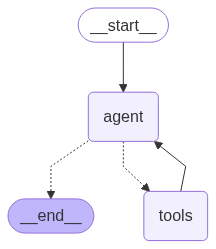

In [1]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

from deep_agents_from_scratch.prompts import TODO_USAGE_INSTRUCTIONS
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.todo_tools import read_todos, write_todos

# Mock search result
search_result = """The Model Context Protocol (MCP) is an open standard protocol developed 
by Anthropic to enable seamless integration between AI models and external systems like 
tools, databases, and other services. It acts as a standardized communication layer, 
allowing AI models to access and utilize data from various sources in a consistent and 
efficient manner. Essentially, MCP simplifies the process of connecting AI assistants 
to external services by providing a unified language for data exchange. """


# Mock search tool
@tool(parse_docstring=True)
def web_search(
    query: str,
):
    """Search the web for information on a specific topic.

    This tool performs web searches and returns relevant results
    for the given query. Use this when you need to gather information from
    the internet about any topic.

    Args:
        query: The search query string. Be specific and clear about what
               information you're looking for.

    Returns:
        Search results from search engine.

    Example:
        web_search("machine learning applications in healthcare")
    """
    return search_result


# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)
tools = [write_todos, web_search, read_todos]

# Add mock research instructions
SIMPLE_RESEARCH_INSTRUCTIONS = """IMPORTANT: Just make a single call to the web_search tool and use the result provided by the tool to answer the user's question."""

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=TODO_USAGE_INSTRUCTIONS
    + "\n\n"
    + "=" * 80
    + "\n\n"
    + SIMPLE_RESEARCH_INSTRUCTIONS,
    state_schema=DeepAgentState,
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

Start the graph with no `todos` in state and an user research request. 

In [2]:
# Example usage
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Give me a short summary of the Model Context Protocol (MCP).",
            }
        ],
        "todos": [],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me a short summary of the Model Context Protocol (MCP).                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a summary of the Model Context Protocol (MCP). Let me search for current information about    │
│ it.                                                                                                             │
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Search for information about Model Context Protocol (MCP) and provide a short summary",       │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01XLwwF4ZpETeicMjR9H3gQM                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for information about Model Context Protocol (MCP) and provide a      │
│ short summary', 'status': 'in_progress'}]                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: web_search                                                                                        │
│    Args: {                                                                                                      │
│   "query": "Model Context Protocol MCP overview summary"                                                        │
│ }                                                                                                               │
│    ID: toolu_01EXHRNJTbFEms1w5peRPgLF                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ The Model Context Protocol (MCP) is an open standard protocol developed                                         │
│ by Anthropic to enable seamless integration between AI models and external systems like                         │
│ tools, databases, and other services. It acts as a standardized communication layer,                            │
│ allowing AI models to access and utilize data from various sources in a consistent and                          │
│ efficient manner. Essentially, MCP simplifies the process of connecting AI assistants                           │
│ to external services by providing a unified language for data exchange.                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: read_todos                                                                                        │
│    Args: {}                                                                                                     │
│    ID: toolu_01DT7WN1XxHhoq3z33t5QFxQ                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Current TODO List:                                                                                              │
│ 1. 🔄 Search for information about Model Context Protocol (MCP) and provide a short summary (in_progress)       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Search for information about Model Context Protocol (MCP) and provide a short summary",       │
│       "status": "completed"                                                                                     │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_019SDE4CmDnBDUv7VnCU1ZLe                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Search for information about Model Context Protocol (MCP) and provide a      │
│ short summary', 'status': 'completed'}]                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ## Model Context Protocol (MCP) Summary                                                                         │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open standard protocol developed by Anthropic that serves as a       │
│ standardized communication layer between AI models and external systems. Here are the key points:               │
│                                                                                                                 │
│ **Purpose**: MCP enables seamless integration between AI assistants and various external services including:    │
│ - Tools and applications                                                                                        │
│ - Databases                                                                                                     │
│ - APIs and other services                                                                                       │
│                                                                                                                 │
│ **Key Benefits**:                                                                                               │
│ - **Standardization**: Provides a unified language for data exchange                                            │
│ - **Simplification**: Streamlines the process of connecting AI models to external resources                     │
│ - **Consistency**: Ensures reliable and efficient data access across different systems                          │
│                                                                                                                 │
│ **How it works**: MCP acts as a bridge that allows AI models to access and utilize data from various sources in │
│ a consistent manner, eliminating the need for custom integrations for each external service.                    │
│                                                                                                                 │
│ This protocol essentially makes it easier for AI assistants to interact with the broader digital ecosystem      │
│ while maintaining standardized communication protocols.                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

https://smith.langchain.com/public/57e530e5-c3bb-4ed6-aff6-c57d06158fe9/r